In [24]:
#importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import LocallyLinearEmbedding
from sklearn import manifold, datasets

from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from sklearn import preprocessing

from sklearn.feature_selection\
    import VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix

import mlflow
import mlflow.sklearn

from os.path import exists

from sklearn.model_selection import train_test_split
from tests import feat_sel_col_test



ImportError: cannot import name 'feat_sel_col_test' from 'tests' (C:\Users\MICHEAL\anaconda3\lib\site-packages\IPython\extensions\tests\__init__.py)

In [25]:
def file_status(datapath1, datapath2):
    first_file_exists = exists(datapath1)
    sec_file_exists = exists(datapath2)
    
    if first_file_exists == True and sec_file_exists == True:
        print("Main File Exists")
        
    else:

        df = pd.read_csv("creditcard.csv")
        #create static dataset and save to csv
        df_static = df[:(int(len(df) * 0.95))]
        
        #crate dataset that will be iterated to mimic continuous dataset
        df_cont = df[(int(len(df) * 0.95)):]
        df_static.to_csv("creditcard_static.csv")
        df_cont.to_csv("creditcard_cont.csv")
        #return df_static, df_cont
        

file_status("creditcard_static.csv", "creditcard_cont.csv")

    
def wrangle(datapath):
    #read data
    df = pd.read_csv(datapath)
    
    return df

df = wrangle("creditcard.csv")
df.head(10)
#df.shape
#df["Class"].unique()

Main File Exists


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [26]:
def cleaning():
    print("Cleaning")
    
cleaning()

Cleaning


In [27]:
#normal vs abnormal data classes: - 
#it is stated in the website that class 1 means not fraudulent transaction while 0 means otherwise
normal = df[df.Class == 0]
fradulent = df[df.Class == 1]



In [28]:
def feat_sel(data):
    """Feature Variance to reduce features
    by select important features with highest variance """
    
    X = data.iloc[:,0:30]
    y = data.iloc[:,30]
    
    
    selector = VarianceThreshold(threshold=0.90) #using a threshold of 90 percent
    Var = selector.fit_transform(X)

    X = data[data.columns[selector.get_support(indices=True)]]
    
    z = pd.concat([X, y], axis=1)
    return z

new_df = feat_sel(df)

#test if there is 17 features after feature variance
#feat_sel_ass(new_df, 17)


new_df.head(10)
#new_df.shape

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,3.68,0


In [29]:
def test_train_split(data):
    leng = len(data.columns) - 1
    X = data.iloc[:,0:leng]
    y = data.iloc[:,leng]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 2020)
    
    #scaling
    scaler = StandardScaler()

    x_train = pd.DataFrame(scaler.fit_transform(x_train))
    x_test = pd.DataFrame(scaler.fit_transform(x_test))
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = test_train_split(new_df)
x_train.head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.097361,-0.053502,0.357627,0.086912,-0.459107,0.485762,-0.044210,0.670118,-0.017860,-0.115439,-0.380544,0.458136,0.766712,-0.194801,0.080189,-0.250253
1,1.303197,-0.604925,1.197578,-0.889257,0.643535,0.707215,-0.333023,0.768961,0.330094,-0.491859,0.075488,0.778671,-0.133124,-1.436331,-0.505059,-0.246380
2,1.236124,1.112122,-0.463844,-0.958554,-0.770322,-0.227638,-0.474407,-0.396993,-0.127599,-0.697774,0.953699,1.061683,-0.092519,-0.149920,0.285775,-0.293175
3,0.770611,1.059689,0.181200,-1.377581,0.674749,0.712211,-0.510812,0.541813,-0.254154,-0.294821,0.500770,0.286140,0.495036,-0.336657,1.064912,-0.349073
4,-1.419538,-0.693603,-0.227763,0.655950,-0.490995,1.723744,2.922904,-0.214259,0.985018,-0.086634,-0.789321,-0.703936,-0.189098,-0.097415,-0.233345,0.150017


In [32]:
def modelling(x_train, y_train):  #x_train, xtest, y_train, y_test
    
    model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')
    model.fit(x_train, y_train)
    
    #eval_ = model.score(x_test, y_test)
    #preds = model.predict(x_test)
    #auc = roc_auc_score(y_test, preds)
    
    
    return model   #auc, eval_, model, preds

#auc, eva_sco, model, preds = modelling(x_train, x_test, y_train, y_test)
model = modelling(x_train, y_train)    #x_train, x_test, y_train, y_test

#print(f"Evaluation Score: {eva_sco}")
#print(f"AUC: {auc}")

#roc_plot

In [33]:
def evaluation(model, x_test, y_test):
    
    eval_ = model.score(x_test, y_test)
    preds = model.predict(x_test)
    auc = roc_auc_score(y_test, preds)
    
    return auc, eval_, preds
    
auc, eva_sco, preds = evaluation(model, x_test, y_test)  #x_train, x_test, y_train, y_test

print(f"Evaluation Score: {eva_sco}")
print(f"AUC: {auc}")

Evaluation Score: 0.9991573329588147
AUC: 0.8063461072674664


C:\Users\MICHEAL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


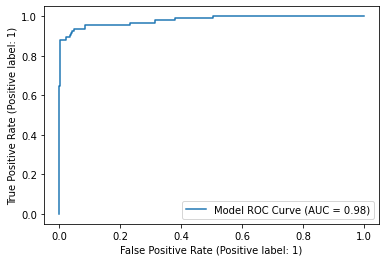

In [12]:
def plot_roc(x_test, y_test, model):
    
    #roc curve
    roc_plot = plot_roc_curve(model, x_test, y_test, name='Model ROC Curve')
    plt.savefig("Model_ROC_Curve.png")
    
    
plot_roc(x_test, y_test, model)

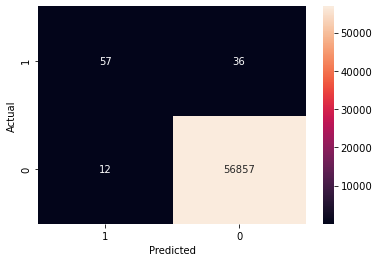

In [13]:
def plot_mat(y_test, y_pred):
    
    #confusion matrix
    mat = confusion_matrix(y_test, y_pred)
    axi = sns.heatmap(mat, annot=True, fmt='g')
    axi.invert_xaxis()
    axi.invert_yaxis()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("Model_Confusion_Matrix.png")
    
plot_mat(y_test, preds)

In [14]:
def flow_logs():
    
    mlflow.log_metric("Evaluation Score", eva_sco)
    mlflow.log_metric("Area under Curve", auc)
    mlflow.log_artifact("Model_ROC_Curve.png")
    mlflow.log_artifact("Model_Confusion_Matrix.png")
    
flow_logs()

In [17]:
sci_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')
mlflow.set_experiment("Fraud Detection")
with mlflow.start_run():
    #train(sci_model, x_train, y_train)
    modelling(x_train, y_train)
    #evaluate(sci_model, x_test, y_test)
    evaluation(model, x_test, y_test)
    mlflow.sklearn.log_model(sci_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Model run:  ddf45abf97ee4bd8851ffbf1d3f4fb82


In [16]:
mlflow.end_run()

In [20]:

for i in range(30):
    pass
    #print("Model")